In [10]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [12]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [13]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [14]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [15]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [16]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

In [17]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

In [18]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

In [19]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

In [20]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [21]:
def to_np(x):
    return x.detach().cpu().numpy()

In [22]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [40]:
import math
import warnings
import numbers
import torch

class grud_model(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers = 1, x_mean = 0,\
     bias =True, batch_first = False, bidirectional = False, dropout_type ='mloss', dropout = 0):
        super(grud_model, self).__init__()

        self.gru_d = GRUD_cell(input_size = input_size, hidden_size= hidden_size, output_size=output_size, 
                dropout=dropout, dropout_type=dropout_type, x_mean=x_mean)
        self.hidden_to_output = torch.nn.Linear(hidden_size, output_size, bias=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        if self.num_layers >1:
            #(batch, seq, feature)
            self.gru_layers = torch.nn.GRU(
                input_size = hidden_size, hidden_size = hidden_size,batch_first = True,
                num_layers = self.num_layers -1, dropout=dropout)

    def forward(self,input):
        output, hidden = self.gru_d(input)
        # batch_size, n_hidden, n_timesteps

        if self.num_layers >1:
            output, hidden = self.gru_layers(hidden)

            output = self.hidden_to_output(output)
            output = torch.sigmoid(output)

        return output

class GRUD_cell(torch.nn.Module):
    """
    Implementation of GRUD.
    Inputs: x_mean
            n_smp x 3 x n_channels x len_seq tensor (0: data, 1: mask, 2: deltat)
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, x_mean=0,\
                 bias=True, batch_first=False, bidirectional=False, dropout_type='mloss',
                 dropout=0, return_hidden = False, return_whole_sequence=False):
      
        print("klu gru")
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        
        super(GRUD_cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        #controls the output, True if another GRU-D layer follows
        self.return_hidden = return_hidden 

        x_mean = torch.tensor(x_mean)
        self.register_buffer('x_mean', x_mean)
        self.bias = bias
        self.batch_first = batch_first
        self.dropout_type = dropout_type
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.return_whole_sequence = return_whole_sequence
        #TODO: Implement bidrectional support
        num_directions = 2 if bidirectional else 1
        
        if not isinstance(dropout, numbers.Number) or not 0 <= dropout <= 1 or \
                isinstance(dropout, bool):
            raise ValueError("dropout should be a number in range [0, 1] "
                             "representing the probability of an element being "
                             "zeroed")
        if dropout > 0 and num_layers == 1:
            warnings.warn("dropout option adds dropout after all but last "
                          "recurrent layer, so non-zero dropout expects "
                          "num_layers greater than 1, but got dropout={} and "
                          "num_layers={}".format(dropout, num_layers))
        
        #set up all the operations that are needed in the forward pass
        self.w_dg_x = torch.nn.Linear(input_size,input_size, bias=True)
        self.w_dg_h = torch.nn.Linear(input_size, hidden_size, bias = True)

        self.w_xz = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_hz = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_mz = torch.nn.Linear(input_size, hidden_size, bias=True)

        self.w_xr = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_hr = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_mr = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_xh = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_hh = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_mh = torch.nn.Linear(input_size, hidden_size, bias=True)

        self.w_hy = torch.nn.Linear(hidden_size, output_size, bias=True)

        Hidden_State = torch.zeros(self.hidden_size, requires_grad = True)
        #we use buffers because pytorch will take care of pushing them to GPU for us
        self.register_buffer('Hidden_State', Hidden_State)
        self.register_buffer('X_last_obs', torch.zeros(input_size)) 

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)
    
    @property
    def _flat_weights(self):
        return list(self._parameters.values())


    def forward(self, input):
        X = input[:,0,:,:]
        Mask = input[:,1,:,:]
        Delta = input[:,2,:,:]
        
        output = None
        h = getattr(self, 'Hidden_State')

        #buffer system from newer pytorch version
        x_mean = getattr(self, 'x_mean')
        x_last_obsv = getattr(self, 'X_last_obs')
        

        device = next(self.parameters()).device
        output_tensor = torch.empty([X.size()[0], X.size()[2], self.output_size], dtype=X.dtype, device= device)
        hidden_tensor = torch.empty(X.size()[0], X.size()[2], self.hidden_size, dtype=X.dtype, device = device)

        #iterate over seq
        for timestep in range(X.size()[2]):
            
            x = torch.squeeze(X[:,:,timestep])
            m = torch.squeeze(Mask[:,:,timestep])
            d = torch.squeeze(Delta[:,:,timestep])
            
            gamma_x = torch.exp(-1* torch.nn.functional.relu( self.w_dg_x(d) ))
            gamma_h = torch.exp(-1* torch.nn.functional.relu( self.w_dg_h(d) ))

            x_last_obsv = torch.where(m>0,x,x_last_obsv)
            #x = m * x + (1 - m) * (gamma_x * x + (1 - gamma_x) * x_mean)
            x = m * x + (1 - m) * (gamma_x * x_last_obsv + (1 - gamma_x) * x_mean)

            if self.dropout == 0:

                h = gamma_h*h
                z = torch.sigmoid( self.w_xz(x) + self.w_hz(h) + self.w_mz(m))
                r = torch.sigmoid( self.w_xr(x) + self.w_hr(h) + self.w_mr(m))

                h_tilde = torch.tanh( self.w_xh(x) + self.w_hh( r*h ) + self.w_mh(m))


                h = (1 - z) * h + z * h_tilde

            elif self.dropout_type == 'Moon':
                '''
                RNNDROP: a novel dropout for rnn in asr(2015)
                '''
                h = gamma_h * h

                z = torch.sigmoid((self.w_xz(x) + self.w_hz(h) + self.w_mz(m)))
                r = torch.sigmoid((self.w_xr(x) + self.w_hr(h) + self.w_mr(m)))

                h_tilde = torch.tanh((self.w_xh(x) + self.w_hh(r * h) + self.w_mh(m)))

                h = (1 - z) * h + z * h_tilde
                dropout = torch.nn.Dropout(p=self.dropout)
                h = dropout(h)

            elif self.dropout_type == 'Gal':
                '''
                A Theoretically grounded application of dropout in recurrent neural networks(2015)
                '''
                dropout = torch.nn.Dropout(p=self.dropout)
                h = dropout(h)

                h = gamma_h * h

                z = torch.sigmoid((self.w_xz(x) + self.w_hz(h) + self.w_mz(m)))
                r = torch.sigmoid((self.w_xr(x) + self.w_hr(h) + self.w_mr(m)))
                h_tilde = torch.tanh((self.w_xh(x) + self.w_hh(r * h) + self.w_mh(m)))

                h = (1 - z) * h + z * h_tilde

            elif self.dropout_type == 'mloss':
                '''
                recurrent dropout without memory loss arXiv 1603.05118
                g = h_tilde, p = the probability to not drop a neuron
                '''
                h = gamma_h*h

                z = torch.sigmoid((self.w_xz(x) + self.w_hz(h) + self.w_mz(m)))
                r = torch.sigmoid((self.w_xr(x) + self.w_hr(h) + self.w_mr(m)))


                dropout = torch.nn.Dropout(p=self.dropout)
                h_tilde = torch.tanh( self.w_xh(x) + self.w_hh( r*h ) + self.w_mh(m))


                h = (1 - z) * h + z * h_tilde

            else:
                h = gamma_h * h

                z = torch.sigmoid((self.w_xz(x) + self.w_hz(h) + self.w_mz(m)))
                r = torch.sigmoid((self.w_xr(x) + self.w_hr(h) + self.w_mr(m)))
                h_tilde = torch.tanh((self.w_xh(x) + self.w_hh(r * h) + self.w_mh(m)))

                h = (1 - z) * h + z * h_tilde

            step_output = self.w_hy(h)
            step_output = torch.sigmoid(step_output)
            output_tensor[:,timestep,:] = step_output
            hidden_tensor[:,timestep,:] = h
        if self.return_whole_sequence:
          output = output_tensor, hidden_tensor
        else:
          output = torch.unsqueeze(output_tensor[:, -1, :], 0), torch.unsqueeze(hidden_tensor[:, -1, :], 0)
        return output

In [41]:
def call_gru_d(gru_d, input):
  #input = (num_time, batch_size, (x, y, t))
  #input_size = (num_time, batch_size, 3)
  #gru input size = (batch_size, 3, 2, num_time)
  #gru input = (batch_size, (X, m, delta))
  input = torch.permute(input, (1, 2, 0))
  gru_input = []
  for i in range(input.shape[0]):
    X = input[i, :2, :]
    m = torch.where(torch.isnan(X), 0, 1)
    time = input[i, 2, :]
    delta = torch.zeros(X.shape)
    for t in range(input.shape[2]):
      #delta[t] = t_diff[t] if m[t] == 1 else delta[t-1] + t_diff[t]
      delta[:,t] = time[t] + (m[:, t] - 1) * delta[:, t-1]
    stacked = torch.stack([X, m, delta])
    gru_input.append(stacked)
  
  gru_input = torch.stack(gru_input)
  return gru_d(gru_input)


In [42]:
import torch.nn as nn
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, encoder='gru'):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = encoder

        if encoder == 'gru':
          self.rnn = nn.GRU(input_dim+1, hidden_dim)
        else:
          self.rnn = GRUD_cell(input_dim, hidden_dim, hidden_dim)#nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        #t[1:] = t[:-1] - t[1:]
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)
        if self.encoder == 'gru':
          _ , h0 = self.rnn(xt.flip((0,)))
        else:
          _ , h0 = call_gru_d(self.rnn, xt.flip(0,)) #self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var

In [43]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs

In [44]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim, encoder='gru'):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim, encoder=encoder)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p

In [56]:
import numpy as np
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

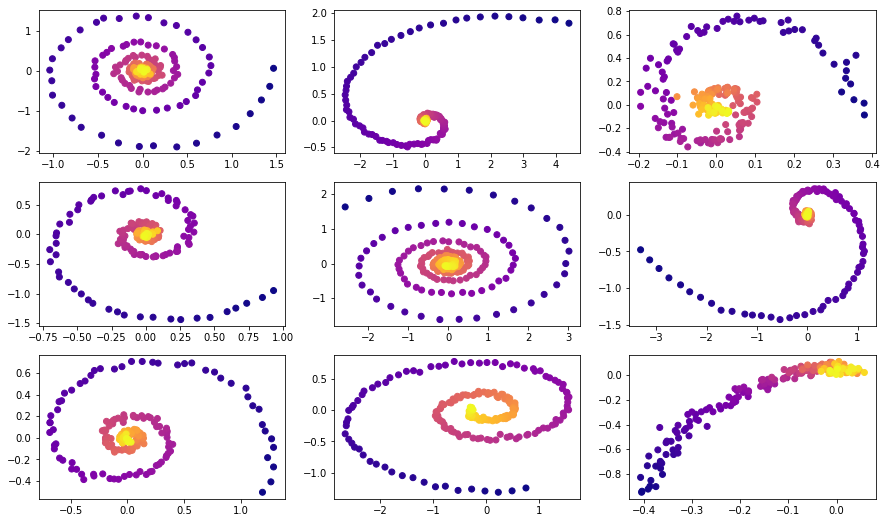

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()

In [59]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [78]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

### Training

In [79]:
vae = ODEVAE(2, 64, 6,encoder='grud')
vae1 = ODEVAE(2, 64, 6)

klu gru


In [80]:
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)
optim1 = torch.optim.Adam(vae1.parameters(), betas=(0.9, 0.999), lr=0.001)

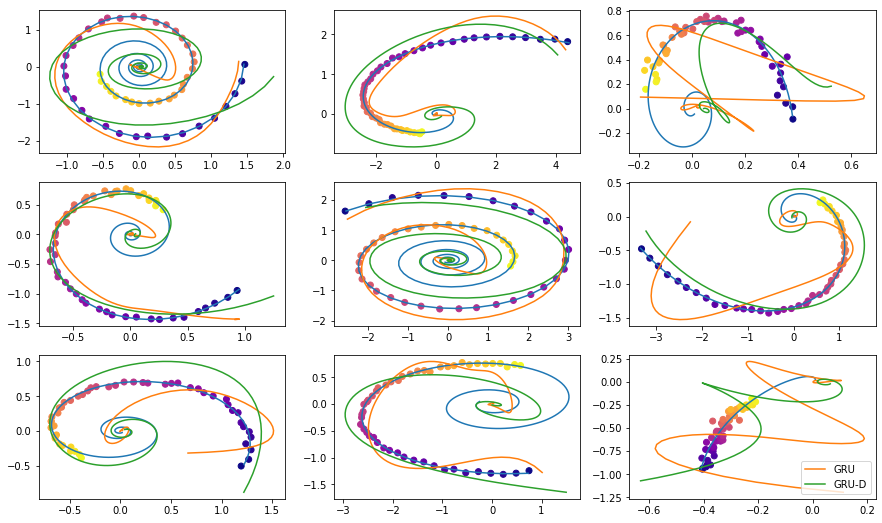

312.8470947265625 299.0013885498047


In [ ]:
preload = False
n_epochs = 20000
batch_size = 100

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))

for epoch_idx in range(n_epochs):
    losses = []
    losses1 = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)

        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)

        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss

        loss = torch.mean(loss)

        loss /= max_len

        loss.backward()

        optim.step()
        losses.append(loss.item())

        optim1.zero_grad()

        x_p1, z1, z_mean1, z_log_var1 = vae1(x, t)

        kl_loss1 = -0.5 * torch.sum(1 + z_log_var1 - z_mean1**2 - torch.exp(z_log_var1), -1)

        loss1 = 0.5 * ((x-x_p1)**2).sum(-1).sum(0) / noise_std**2 + kl_loss1

        loss1 = torch.mean(loss1)

        loss1 /= max_len

        loss1.backward()

        optim1.step()
        losses1.append(loss1.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))
    print(samp_trajs_p)
    samp_trajs_p1 = to_np(vae1.generate_with_seed(seed_trajs, ts))
    print(samp_trajs_p1)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p1[:, i, 0], samp_trajs_p1[:, i, 1], label='GRU')
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1], label='GRU-D')
    plt.legend()
    plt.savefig('/content/drive/My Drive/neural-ode-master/vis/plt' + str(epoch_idx))
    plt.show()

    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

In [ ]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = Tensor(np.linspace(0., 1., 10)[:, None])
vae = vae
if use_cuda:
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx:spiral_0_idx+1, :]
spiral_1 = orig_trajs[:, spiral_1_idx:spiral_1_idx+1, :]
ts_0 = samp_ts[:, spiral_0_idx:spiral_0_idx+1, :]
ts_1 = samp_ts[:, spiral_1_idx:spiral_1_idx+1, :]
if use_cuda:
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6*np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None].cuda()
t = t.cuda() if use_cuda else t
hom_gen_trajs = vae.decoder(homotopy_z, t)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()

This is what I got after a night of training
![spiral reconstruction with seed](assets/spirals_reconstructed.png)
<div align="center">Dots are noisy observations of the original trajectories (blue), <br /> yellow are reconstructed and interpolated trajectories using dots as inputs. <br /> Color of the dots represents time. </div>